In [2]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import hdbscan

In [3]:
#%pip install --user --upgrade --only-binary=:all: --prefer-binary \
 # numpy==1.26.4 scipy==1.10.1 scikit-learn==1.2.2 hdbscan==0.8.40




In [4]:
# torch-only correlation with score for BordeauxWines.csv

# ---------- config ----------
CSV_PATH = "BordeauxWines.csv"
SCORE_CANDIDATES = ["score","Score","quality","Quality","rating","Rating","points","Points"]
ADD_SQUARED_FEATURES = False      # set True if you want x^2 columns like the slide
SAVE_CSV = True
TOP_K = 30                        # top 60 features by absolute correlation

# ---------- load & prepare ----------
df = pd.read_csv(CSV_PATH)

# keep numeric columns
df_num = df.select_dtypes(include=[np.number]).copy()

# choose or create a score column
score_col = next((c for c in SCORE_CANDIDATES if c in df_num.columns), None)
if score_col is None:
    score_col = "total_score"
    df_num[score_col] = df_num.dropna(axis=1).fillna(0.0).sum(axis=1)

# X features (drop target), y target
X_df = df_num.drop(columns=[score_col]).fillna(0.0)
y_df = df_num[score_col].astype(float)

# (optional) add squared terms like x^2
if ADD_SQUARED_FEATURES:
    X_sq = X_df ** 2
    X_sq.columns = [f"{c}^2" for c in X_sq.columns]
    X_df = pd.concat([X_df, X_sq], axis=1)

# convert to torch
device = "cuda" if torch.cuda.is_available() else "cpu"
X = torch.tensor(X_df.values, dtype=torch.float32, device=device)
y = torch.tensor(y_df.values, dtype=torch.float32, device=device).view(-1, 1)

# ---------- pearson correlation (torch) ----------
# center
Xc = X - X.mean(dim=0, keepdim=True)
yc = y - y.mean(dim=0, keepdim=True)

# std with epsilon to avoid /0
eps = 1e-12
Xstd = Xc.pow(2).sum(dim=0).div(X.shape[0]-1).sqrt().clamp_min(eps)  # (d,)
ystd = yc.pow(2).sum(dim=0).div(X.shape[0]-1).sqrt().clamp_min(eps)  # (1,)

# covariance between each feature and y
cov_xy = (Xc * yc).sum(dim=0).div(X.shape[0]-1)                      # (d,)

# correlation for each feature with y
corr_xy = cov_xy / (Xstd * ystd.squeeze())                           # (d,)

# move back to cpu + pandas
corr_series = pd.Series(corr_xy.detach().cpu().numpy(), index=X_df.columns, name=f"corr_with_{score_col}")

# ---------- top features by absolute correlation ----------
corr_abs_sorted = corr_series.abs().sort_values(ascending=False)
top_features = corr_abs_sorted.head(TOP_K)
top_features_values = corr_series[top_features.index]  # keep original sign

# add label column for positive/negative
top_features_df = pd.DataFrame({
    "correlation": top_features_values,
    "sign": ["positive" if v >= 0 else "negative" for v in top_features_values]
})

# ---------- outputs ----------
print(f"\nTop {TOP_K} features by absolute correlation with {score_col}:\n")
print(top_features_df)

if SAVE_CSV:
    out_path = "feature_score_correlation_torch_top60.csv"
    top_features_df.to_csv(out_path, header=True)
    print(f"\nSaved top {TOP_K} features to: {out_path}")



Top 30 features by absolute correlation with Score:

               correlation      sign
GREAT             0.335469  positive
LONG              0.317780  positive
MEDIUM-BODIED    -0.272295  negative
CHARACTER        -0.244106  negative
LIGHT-BODIED     -0.232344  negative
FULL-BODIED       0.221209  positive
BLACKBERRY        0.219325  positive
FIG               0.214505  positive
HERBS            -0.214154  negative
BLACK CURRANT     0.195338  positive
BEAUTY            0.192052  positive
Year              0.189012  positive
BERRY            -0.178139  negative
POWER             0.172462  positive
DENSE             0.170415  positive
PENCIL LEAD       0.168566  positive
WARM              0.167754  positive
APPLE             0.167546  positive
FLAVORS           0.167008  positive
LOVELY            0.166112  positive
RICH              0.164799  positive
GORGEOUS          0.164512  positive
MODEST           -0.163695  negative
PURE              0.160996  positive
BOYSENBERRY       0.1

In [5]:
#defining features and target
feature_list = top_features.index.tolist()

score_col = "total_score"
if "Score" in df.columns: score_col = "Score"
elif "score" in df.columns: score_col = "score"
else: df[score_col] = df[feature_list].sum(axis=1) 
df_filtered = df[feature_list + [score_col]] 
df_filtered.to_csv("BordeauxWines_top30.csv",index=False)

X = df_filtered[feature_list].to_numpy(dtype=np.float64) 
y = df_filtered[score_col].to_numpy(dtype=np.float64)

In [6]:
#train and testing
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

df total rows: 14349
rows clustered: 11479
labels len    : 11479
probs  len    : 11479
memberships   : (11479, 11)
Clusters found (excluding noise): 11
Noise points among clustered rows: 7002

Score by cluster (noise excluded):
                     mean  median  count
HDBSCAN_Label                          
9.0            87.806452    88.0    217
2.0            87.716346    88.0    208
10.0           87.627957    88.0    930
3.0            87.619697    88.0    660
5.0            87.583987    88.0    637
4.0            87.582278    88.0    395
6.0            87.517241    88.0    261
1.0            87.434389    88.0    221
0.0            87.299065    88.0    214
8.0            87.220441    87.0    499
7.0            87.217021    87.0    235


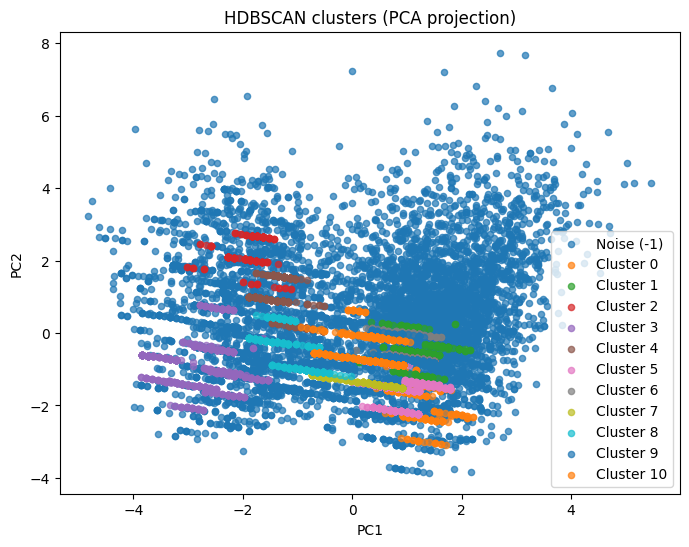

In [7]:
# --- Canonical, index-safe HDBSCAN flow ---
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan
import matplotlib.pyplot as plt

# 0) Config
target_col = "Score"           # change if needed
feature_cols = feature_list    # your list of feature names
min_cluster_size = 200
min_samples = min_cluster_size // 2

# 1) Build source matrix and mask rows that are fully valid for clustering
#X_src = df[feature_cols]
X_src = pd.DataFrame(Xtr.numpy(), columns=feature_cols)
row_mask = X_src.notnull().all(axis=1) & np.isfinite(X_src.values).all(axis=1)

idx = X_src.index[row_mask]              # indices we will cluster on
X_valid = X_src.loc[idx]                 # DataFrame subset used for clustering

# 2) Scale and fit HDBSCAN on exactly these rows
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_valid.values)

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric="manhattan",
    cluster_selection_method="eom",
    allow_single_cluster=False,
    prediction_data=True,
    gen_min_span_tree=True
).fit(X_scaled)

labels      = clusterer.labels_
probs       = clusterer.probabilities_
memberships = hdbscan.all_points_membership_vectors(clusterer)

# 3) Diagnostics (these three MUST match)
print("df total rows:", len(df))
print("rows clustered:", len(idx))
print("labels len    :", len(labels))
print("probs  len    :", len(probs))
print("memberships   :", memberships.shape)  # (rows_clustered, n_clusters_found)

# If this assert fails, it means you still aren't fitting on the same rows you think you are.
assert len(labels) == len(idx) == memberships.shape[0]

# 4) Write back ONLY to the clustered rows (avoid length mismatch)
df["HDBSCAN_Label"] = np.nan
df["HDBSCAN_Prob"]  = np.nan
df.loc[idx, "HDBSCAN_Label"] = labels
df.loc[idx, "HDBSCAN_Prob"]  = probs

# 5) Safer cluster counts
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = int((labels == -1).sum())
print("Clusters found (excluding noise):", n_clusters)
print("Noise points among clustered rows:", n_noise)

# 6) Optional: summary over the clustered rows, excluding noise
if target_col in df.columns:
    summary = (
        df.loc[idx][df.loc[idx, "HDBSCAN_Label"] >= 0]
          .groupby("HDBSCAN_Label")[target_col]
          .agg(["mean", "median", "count"])
          .sort_values("mean", ascending=False)
    )
    print("\nScore by cluster (noise excluded):\n", summary)

# 7) PCA visualization uses the same X_scaled and same idx
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
uniq = np.unique(labels)
for lbl in uniq:
    mask = (labels == lbl)
    label_name = f"Cluster {lbl}" if lbl >= 0 else "Noise (-1)"
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=20, alpha=0.7, label=label_name)
plt.title("HDBSCAN clusters (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.show()

# 8) Torch tensors (match clustered rows only)
labels_t     = torch.as_tensor(labels, dtype=torch.long)
prob_t       = torch.as_tensor(probs, dtype=torch.float32)
membership_t = torch.as_tensor(memberships, dtype=torch.float32)


In [8]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, normalize
from sklearn.decomposition import PCA
import numpy as np, hdbscan

X_scaled = scaler.fit_transform(X_valid)   # your StandardScaler step
X_cos = normalize(X_scaled, norm="l2")    # cosine normalization

# ---- 2) HDBSCAN, tuned to reduce noise ----
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=min_samples,
    metric="manhattan",                 # try "cosine" first; fallback to "euclidean" if needed
    cluster_selection_method="leaf", # less conservative than EOM → fewer noise points
    cluster_selection_epsilon=0.05,  # small epsilon merges tiny gaps
    allow_single_cluster=True,
    prediction_data=True
).fit(X_cos)

labels = clusterer.labels_
probs  = clusterer.probabilities_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_ratio = (labels == -1).mean()
print(f"clusters={n_clusters}, noise_ratio={noise_ratio:.2%}")

# ---- 3) (Optional) Assign remaining noise to nearest cluster (“rescue step”) ----
# If you truly want 0 noise, push leftovers to the closest cluster core by cosine distance.
if n_clusters > 0 and noise_ratio > 0:
    # pick exemplars as cluster representatives
    ex_idx = []
    for c in range(n_clusters):
        members = np.where(labels == c)[0]
        if len(members) == 0: 
            continue
        # choose the highest-probability member as a prototype
        m = members[np.argmax(probs[members])]
        ex_idx.append(m)
    reps = X_cos[ex_idx]

    from sklearn.metrics import pairwise_distances
    noise_mask = (labels == -1)
    D = pairwise_distances(X_cos[noise_mask], reps, metric="cosine")
    nearest = D.argmin(axis=1)
    # ONLY reassign noise with reasonable confidence margin
    # (nearest much closer than the second-nearest)
    second = np.partition(D, 1, axis=1)[:,1]
    margin = (second - D.min(axis=1))
    confident = margin > 0.05
    labels_rescued = labels.copy()
    labels_rescued[np.where(noise_mask)[0][confident]] = nearest[confident]

    labels = labels_rescued
    noise_ratio = (labels == -1).mean()
    print(f"after rescue: noise_ratio={noise_ratio:.2%}")

# ---- 4) Write back to df only on idx ----
df.loc[idx, "HDBSCAN_Label"] = labels
df.loc[idx, "HDBSCAN_Prob"]  = probs


clusters=16, noise_ratio=50.17%
after rescue: noise_ratio=7.52%


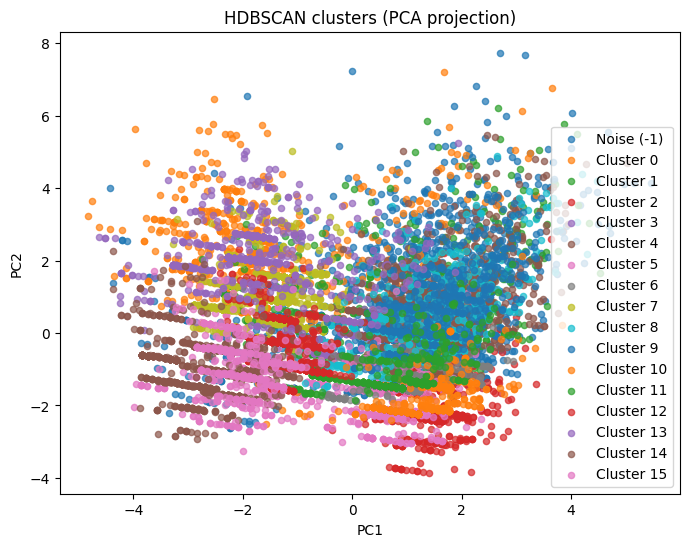

In [9]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
uniq = np.unique(labels)
for lbl in uniq:
    mask = labels == lbl
    label_name = f"Cluster {lbl}" if lbl >= 0 else "Noise (-1)"
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=20, alpha=0.7, label=label_name)
plt.title("HDBSCAN clusters (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.show()

In [10]:
import numpy as np
import pandas as pd

mask_core = labels >= 0
cluster_ids = sorted(set(labels[mask_core]))

# Size, persistence (if available), confidence, target summary
persistence = getattr(clusterer, 'cluster_persistence_', None)
pers_map = {i:p for i,p in zip(clusterer.labels_[clusterer.labels_>=0], 
                               clusterer.probabilities_[clusterer.labels_>=0])} if persistence is None else None

rows=[]
for c in cluster_ids:
    m = labels==c
    rows.append(dict(
        cluster=c,
        size=int(m.sum()),
        mean_prob=float(probs[m].mean()),
        score_mean=float(df.loc[idx, "Score"][m].mean()) if "Score" in df else np.nan,
        score_median=float(df.loc[idx, "Score"][m].median()) if "Score" in df else np.nan
    ))
info = pd.DataFrame(rows).sort_values(["size"], ascending=False)
print(info.head(20))


    cluster  size  mean_prob  score_mean  score_median
4         4  1032   0.289053   87.489341          88.0
3         3   994   0.517006   87.474849          88.0
14       14   901   0.510214   87.480577          88.0
9         9   785   0.288437   87.354140          88.0
7         7   779   0.522861   87.499358          88.0
12       12   729   0.545131   87.272977          87.0
8         8   729   0.305476   87.581619          88.0
1         1   620   0.333825   87.606452          88.0
13       13   593   0.398965   87.578415          88.0
6         6   586   0.483333   87.569966          88.0
0         0   501   0.647149   87.520958          88.0
5         5   501   0.664168   87.518962          88.0
15       15   477   0.487776   87.834382          88.0
10       10   473   0.729917   87.507400          88.0
11       11   467   0.486648   87.464668          88.0
2         2   449   0.694132   87.155902          87.0


clusters=24, noise_ratio=49.10%
after rescue: noise_ratio=12.42%


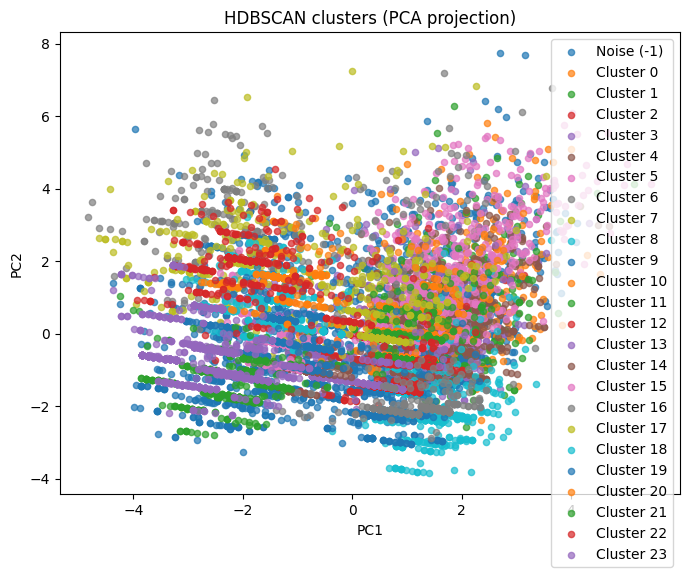

In [11]:
#refitting

# --- inputs you already have ---
feature_cols = feature_list                 # list of columns you cluster on
target_col   = "Score"                  # optional

# 0) pick rows that are valid for clustering
#X_src = df[feature_cols]
X_src = pd.DataFrame(Xtr.numpy(), columns=feature_cols)
row_mask = X_src.notnull().all(axis=1) & np.isfinite(X_src.values).all(axis=1)
idx = X_src.index[row_mask]             # indices we will cluster on

# 1) preprocessing -> X_unit (this is what 'X_unit' should be)
X0 = X_src.loc[idx].values
X1 = StandardScaler().fit_transform(X0)
X1 = PowerTransformer(method="yeo-johnson").fit_transform(X1)
X1 = PCA(n_components=0.95, random_state=42).fit_transform(X1)
X_unit = normalize(X1)        

N = X_unit.shape[0]  # space you fitted on
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=max(30, int(0.01 * N)),  # 1–2% of N is a good start
    min_samples=100,                             # stricter core definition
    metric="manhattan",                        # (on L2-normalized data)
    cluster_selection_method="eom",            # merges leaves
    cluster_selection_epsilon=0.02,            # small bridge to join near-leaves
    allow_single_cluster=True,
    prediction_data=True
).fit(X_unit)
labels = clusterer.labels_; probs = clusterer.probabilities_


probs  = clusterer.probabilities_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_ratio = (labels == -1).mean()
print(f"clusters={n_clusters}, noise_ratio={noise_ratio:.2%}")

# ---- 3) (Optional) Assign remaining noise to nearest cluster (“rescue step”) ----
# If you truly want 0 noise, push leftovers to the closest cluster core by cosine distance.
if n_clusters > 0 and noise_ratio > 0:
    # pick exemplars as cluster representatives
    ex_idx = []
    for c in range(n_clusters):
        members = np.where(labels == c)[0]
        if len(members) == 0: 
            continue
        # choose the highest-probability member as a prototype
        m = members[np.argmax(probs[members])]
        ex_idx.append(m)
    reps = X_cos[ex_idx]

    from sklearn.metrics import pairwise_distances
    noise_mask = (labels == -1)
    D = pairwise_distances(X_cos[noise_mask], reps, metric="cosine")
    nearest = D.argmin(axis=1)
    # ONLY reassign noise with reasonable confidence margin
    # (nearest much closer than the second-nearest)
    second = np.partition(D, 1, axis=1)[:,1]
    margin = (second - D.min(axis=1))
    confident = margin > 0.05
    labels_rescued = labels.copy()
    labels_rescued[np.where(noise_mask)[0][confident]] = nearest[confident]

    labels = labels_rescued
    noise_ratio = (labels == -1).mean()
    print(f"after rescue: noise_ratio={noise_ratio:.2%}")

# ---- 4) Write back to df only on idx ----
df.loc[idx, "HDBSCAN_Label"] = labels
df.loc[idx, "HDBSCAN_Prob"]  = probs
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
uniq = np.unique(labels)
for lbl in uniq:
    mask = labels == lbl
    label_name = f"Cluster {lbl}" if lbl >= 0 else "Noise (-1)"
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=20, alpha=0.7, label=label_name)
plt.title("HDBSCAN clusters (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.show()



<Axes: ylabel='$\\lambda$ value'>

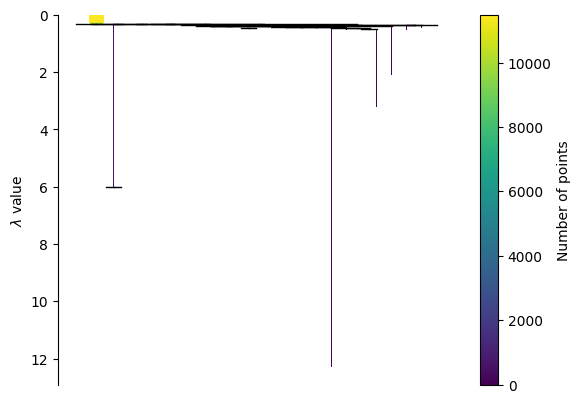

In [12]:
clusterer.condensed_tree_.plot()

In [13]:
import numpy as np

# Only use valid (non-noise) clusters
valid_mask = labels >= 0
cluster_ids = np.unique(labels[valid_mask])

centers = []
sigmas = []

for c in cluster_ids:
    members = X_unit[labels == c]
    centers.append(members.mean(axis=0))
    sigmas.append(members.std(axis=0) + 1e-6)  # avoid zeros

centers = np.vstack(centers)
sigmas  = np.vstack(sigmas)

In [14]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        #diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)
        diff = (x.unsqueeze(1) - self.centers.unsqueeze(0)) / (self.sigmas.unsqueeze(0) + eps)
        diff = torch.abs(diff)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)
    
# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(torch.randn(n_inputs + 1,n_rules))

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs

In [15]:
#model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

import torch

def pad_to_match(t, target_cols):
    if t.shape[1] < target_cols:
        pad_cols = target_cols - t.shape[1]
        t = torch.cat([t, torch.zeros(t.shape[0], pad_cols)], dim=1)
    return t

model = TSK( n_inputs=Xtr.shape[1], 
            n_rules=n_clusters, 
            centers=pad_to_match(torch.tensor(centers, dtype=torch.float32), Xtr.shape[1]), 
            sigmas=pad_to_match(torch.tensor(sigmas, dtype=torch.float32), Xtr.shape[1])
        )

C:\Users\kaliv\AppData\Local\Temp\ipykernel_908\2209811058.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
C:\Users\kaliv\AppData\Local\Temp\ipykernel_908\2209811058.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))


In [16]:
# Least Squares Solver for Consequents (TSK)
#to get the optimal a and b already optimal
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        model.consequents.data = theta.reshape(model.consequents.shape)

In [17]:
train_ls(model, Xtr, ytr.reshape(-1,1))

In [25]:
y_pred, _, _=model(Xte)

#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)

        # Handle zero variance case
    if y_true_var == 0:
        if np.allclose(y_true, y_pred):
            return 100.0  # Perfect prediction
        else:
            return 0.0  # or np.nan, depending on your preference
        
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

MSE:7709.8955078125
VAF = -0.00%


ANFIS

In [19]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()

In [20]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=5, gd_epochs=10, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [21]:
def pad_to_match(tensor, target_dim):
    diff = target_dim - tensor.shape[1]
    if diff > 0:
        pad = torch.zeros((tensor.shape[0], diff))
        return torch.cat([tensor, pad], dim=1)
    else:
        return tensor[:, :target_dim]


In [22]:
# Build model
#model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])
model = TSK(
    n_inputs=Xtr.shape[1],
    n_rules=n_clusters,
    centers=pad_to_match(torch.tensor(centers, dtype=torch.float32), Xtr.shape[1]),
    sigmas=pad_to_match(torch.tensor(sigmas, dtype=torch.float32), Xtr.shape[1])
)

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

C:\Users\kaliv\AppData\Local\Temp\ipykernel_908\2209811058.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
C:\Users\kaliv\AppData\Local\Temp\ipykernel_908\2209811058.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
C:\Users\kaliv\AppData\Local\Temp\ipykernel_908\2068588504.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtr = torch.tensor(Xtr, dtype=torch.float32)
C:\Users\kaliv\AppData\

In [23]:
# Training with ANFIS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))

tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLossBackward0>)
tensor(7722.2344, grad_fn=<MseLoss

In [26]:
y_pred, _, _=model(Xte)
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

def vaf(y_true, y_pred):
    # Convert tensors to NumPy if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()
    
    y_true_var = np.var(y_true)

        # Handle zero variance case
    if y_true_var == 0:
        if np.allclose(y_true, y_pred):
            return 100.0  # Perfect prediction
        else:
            return 0.0  # or np.nan, depending on your preference
           
    return (1 - np.var(y_true - y_pred) / y_true_var) * 100

# Example usage
print(f"VAF = {vaf(yte, y_pred):.2f}%")

MSE:7709.8955078125
VAF = -0.00%
